In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/', '')
  
import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import algos_factory
from deepiu.seq2seq.rnn_decoder import SeqDecodeMethod

#debug
from deepiu.util import text2ids

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'

#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.keywords/'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/bak/showattentell.keywords.luong.batch32/'
FLAGS.model_dir = model_dir

image_model_name = melt.image.get_imagenet_from_checkpoint(image_model_checkpoint_path).name
FLAGS.image_model_name = image_model_name
if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, feature_name='attention')
else:
  image_model = None
print('image_model', image_model)

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.4.0-rc1


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


ENCODE_UNK 1
checkpoint /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt model_name InceptionResnetV2 height 299 width 299
build graph for final one feature
preprocessing_fn net_name inception_resnet_v2 height 299 width 299


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten/flatten/Reshape:0", shape=(?, 98304), dtype=float32)
build graph for attention features
preprocessing_fn net_name inception_resnet_v2 height 299 width 299
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten_1/flatten/Reshape:0", shape=(?, 98304), dtype=float32)


INFO:tensorflow:Restoring parameters from /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt
image_model <melt.image.image_model.ImageModel object at 0x7fc9cc5cbed0>


restore image var from InceptionResnetV2 /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt duration: 5.00675296783


In [2]:
if 'coverage' in model_dir:
  FLAGS.coverage_attention_wrapper = True

FLAGS.attention_option = 'luong'
FLAGS.image_encoder = 'Rnn'
FLAGS.showtell_encode_scope = 'encode'
FLAGS.showtell_decode_scope = 'decode'
FLAGS.image_endpoint_feature_name = 'attention'
FLAGS.image_checkpoint_file = image_model_checkpoint_path 
FLAGS.pre_calc_image_feature = 1 
FLAGS.finetune_image_model = True 
FLAGS.image_features_batch_norm = True 
FLAGS.emb_dim = 512 
FLAGS.rnn_hidden_size = 512 
FLAGS.alignment_history = True

FLAGS.image_attention_size = FLAGS.image_attention_size or melt.image.get_num_features(FLAGS.image_model_name)
FLAGS.image_feature_len = FLAGS.image_feature_len or melt.image.get_feature_dim(FLAGS.image_model_name) * FLAGS.image_attention_size

beam_size = 100
length_normalization_factor = 1.

In [3]:
algo = 'show_and_tell'
global_scope = algo
main_scope = 'main'
melt.apps.image_processing.init()
with tf.variable_scope(global_scope):
  with tf.variable_scope(main_scope):
    predictor =  algos_factory.gen_predictor(algo)
    predictor.init_predict_text(decode_method=SeqDecodeMethod.ingraph_beam, 
                                beam_size=beam_size,
                                length_normalization_factor=length_normalization_factor,
                                logprobs_history=True,
                                alignment_history=True,
                                max_words=5)  

predictor.load(FLAGS.model_dir) 

cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
rnn decoder gen only mode
attention_mechanism: <melt.seq2seq.attention_wrapper.LuongAttention object at 0x7fc970bb4f10>


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model.v4/bak/showattentell.keywords.luong.batch32/epoch/model.ckpt-2.00-13124


restore ok: /home/gezi/new/temp/image-caption/ai-challenger/model.v4/bak/showattentell.keywords.luong.batch32/epoch/model.ckpt-2.00-13124
load model ok /home/gezi/new/temp/image-caption/ai-challenger/model.v4/bak/showattentell.keywords.luong.batch32/epoch/model.ckpt-2.00-13124 duration: 0.344215869904


In [4]:
def simple_predict(image_path, predictor):
  timer = gezi.Timer('beam search using time')
  img = melt.read_image(image_path)
  if image_model:
    #attention model gen features only
    feature = image_model.gen_features(img) if image_model is not None else img
  else:
    feature = [img]    
  #texts_list, scores_list = predictor.predict_text(feature)
  #timer.print()
  logprobs_history = None 
  alignment_history = None

  l = predictor.predict_text(feature)
  timer.print()
  texts_list, scores_list= l[0], l[1]
  try:
    logprobs_history = l[2]
    alignment_history = l[3]
  except Exception:
    pass

  #print(alignment_history)

  texts = texts_list[0]
  scores = scores_list[0]
  if logprobs_history is not None:
    logprobs = logprobs_history[0]
  else:
    logprobs = [None] * len(texts)
  if alignment_history is not None:
    alignments = alignment_history[0]
  else:
    alignments = [None] * len(texts)
    
  logprob = None 
  alignment = None 
    
  for text, score, logprob, alignment in zip(texts, scores, logprobs, alignments):
    print('align shape', alignment.shape)
    print(ids2text.ids2text(text), score)
    print(text, len(text))
    if logprob is not None:
      print(map(math.exp, logprob))
    #if alignment is not None:
    #  print(alignment)
    #  print(alignment[10], alignment[11], alignment[12])


In [5]:
#simple_predict(image_path, predictor)

In [6]:
def predict(image_path, predictor, length_normalization_factor=0.25, num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  texts, scores, logprobs_history, alignment_history = predictor.predict_text(feature)
  for i, (text, score, logprob, alignment) in enumerate(zip(texts[0], scores[0], logprobs_history[0], alignment_history[0])):
    print(ids2text.ids2text(text), score)

    # Plot images with attention weights
    words = ids2text.ids2words(text) 
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 100:  
      print('probs', [math.exp(x) for x in logprob])
      for j in range(len(words)):
        #if i == 0:
        #  print(i, j, words[j], alignment[j])
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(words[j].decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(logprob[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(alignment[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(alignment[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    print('beam search using time(ms):', timer.elapsed_ms())

In [ ]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 601013467957beaa6f85ffbbe46b1093b764ea5c


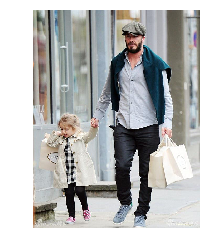

牵着 牵着 牵着 走 </S> 0.0181329
probs [0.4874366389777467, 0.23545085727454396, 0.11901787030550176, 0.12926887164869086, 1.1102365025221012e-06]


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


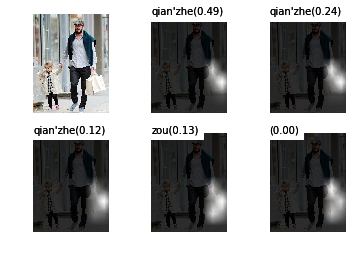

beam search using time(ms): 1375.05102158
牵着 牵着 拎 走 </S> 0.018053
probs [0.4874366389777467, 0.23545085727454396, 0.11648311910579962, 0.12904217308045873, 1.1115629168891233e-06]


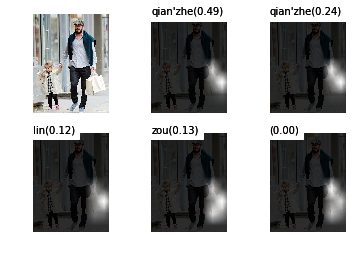

beam search using time(ms): 612.582921982
牵着 牵着 走 走 </S> 0.0175815
probs [0.4874366389777467, 0.23545085727454396, 0.10625782209478847, 0.12330461402939712, 1.117160346520983e-06]


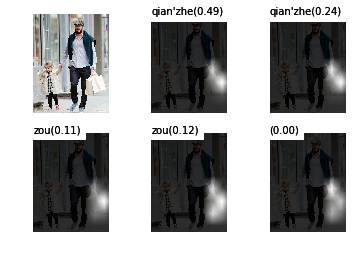

beam search using time(ms): 619.765043259
牵着 牵着 牵着 拎 </S> 0.017397
probs [0.4874366389777467, 0.23545085727454396, 0.11901787030550176, 0.09965222571518095, 1.1707393788257605e-06]


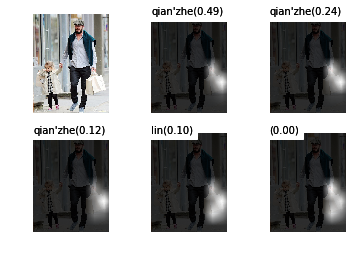

beam search using time(ms): 641.360998154
牵着 牵着 袋子 走 </S> 0.0173554
probs [0.4874366389777467, 0.23545085727454396, 0.09561247983116125, 0.1290641726823919, 1.1118322070305696e-06]


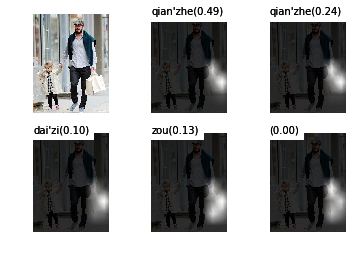

beam search using time(ms): 685.877084732
牵着 牵着 拎 拎 </S> 0.0173199
probs [0.4874366389777467, 0.23545085727454396, 0.11648311910579962, 0.09946949711562408, 1.1720911285317111e-06]


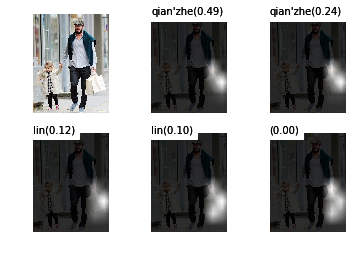

beam search using time(ms): 622.117042542
牵着 袋子 牵着 走 </S> 0.0172607
probs [0.4874366389777467, 0.18572766860689452, 0.11848101767826572, 0.12885122654768597, 1.108558508644295e-06]


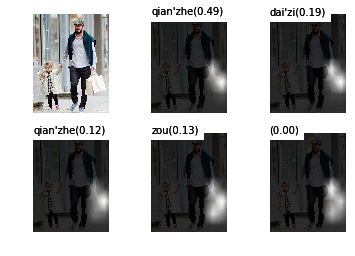

beam search using time(ms): 730.625867844
牵着 袋子 拎 走 </S> 0.0171956
probs [0.4874366389777467, 0.18572766860689452, 0.11632919882163549, 0.12862440173946846, 1.1098786844303784e-06]


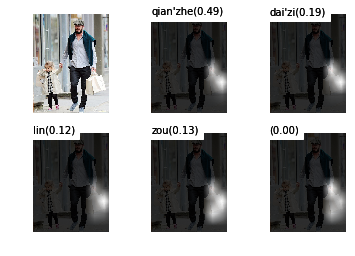

beam search using time(ms): 679.536104202
牵着 牵着 走 拎 </S> 0.0169154
probs [0.4874366389777467, 0.23545085727454396, 0.10625782209478847, 0.09641238346362402, 1.1778697864504388e-06]


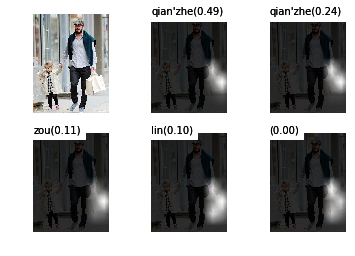

beam search using time(ms): 718.682050705
牵着 袋子 走 走 </S> 0.0167533
probs [0.4874366389777467, 0.18572766860689452, 0.10635976366416386, 0.12288514195761192, 1.1153878512663256e-06]


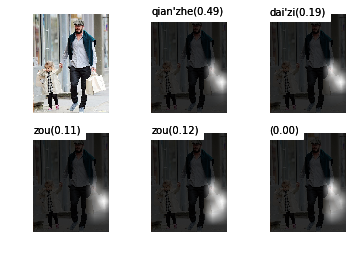

beam search using time(ms): 713.399887085
牵着 牵着 袋子 拎 </S> 0.016648
probs [0.4874366389777467, 0.23545085727454396, 0.09561247983116125, 0.09941001303005519, 1.1723214165521951e-06]


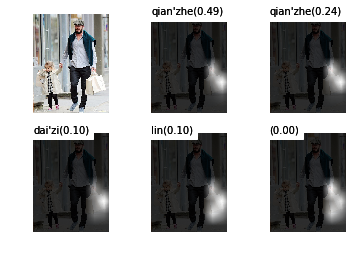

beam search using time(ms): 719.214916229
牵着 袋子 牵着 拎 </S> 0.0165712
probs [0.4874366389777467, 0.18572766860689452, 0.11848101767826572, 0.09965733401864839, 1.169014535373266e-06]


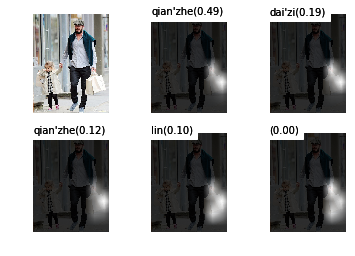

beam search using time(ms): 785.298109055
牵着 袋子 袋子 走 </S> 0.0165163
probs [0.4874366389777467, 0.18572766860689452, 0.09505901044171451, 0.12864501124287525, 1.110147566545261e-06]


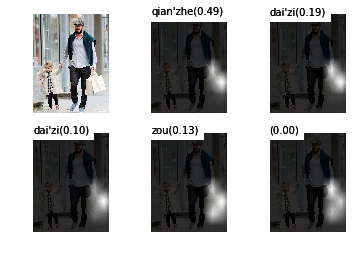

beam search using time(ms): 720.097064972
牵着 袋子 拎 拎 </S> 0.0165083
probs [0.4874366389777467, 0.18572766860689452, 0.11632919882163549, 0.0994743114534894, 1.1703654097012118e-06]


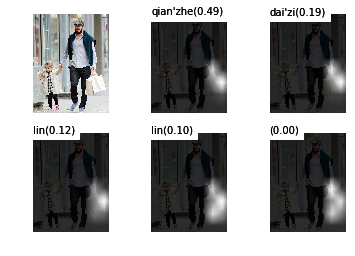

beam search using time(ms): 678.383827209
牵着 牵着 牵着 牵着 </S> 0.0161454
probs [0.4874366389777467, 0.23545085727454396, 0.11901787030550176, 0.06817417515158687, 1.178127051195043e-06]


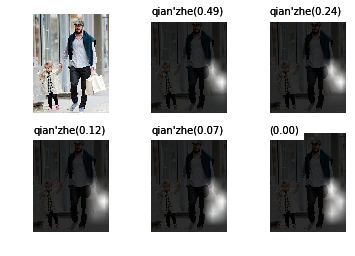

beam search using time(ms): 814.946174622
牵着 袋子 走 拎 </S> 0.0161297
probs [0.4874366389777467, 0.18572766860689452, 0.10635976366416386, 0.09641033768651992, 1.1760794782833064e-06]


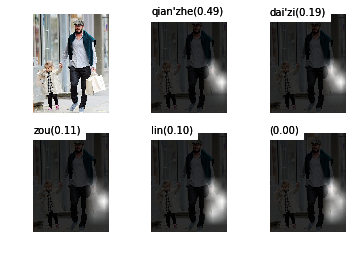

beam search using time(ms): 745.16582489
牵着 拎 牵着 走 </S> 0.0160916
probs [0.4874366389777467, 0.13095106617174246, 0.11850794115314912, 0.12882760462845702, 1.1071744364451704e-06]


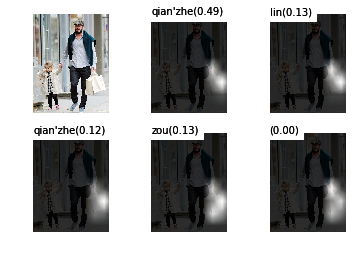

beam search using time(ms): 663.899183273
牵着 牵着 拎 牵着 </S> 0.016064
probs [0.4874366389777467, 0.23545085727454396, 0.11648311910579962, 0.06784110198401955, 1.1794862059497382e-06]


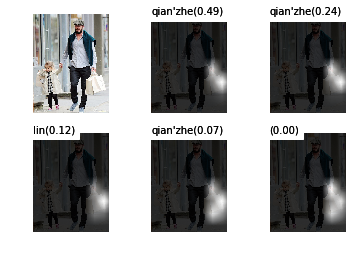

beam search using time(ms): 1018.64099503
牵着 拎 拎 走 </S> 0.0160318
probs [0.4874366389777467, 0.13095106617174246, 0.11638859470532949, 0.12859953365516233, 1.1084908496673167e-06]


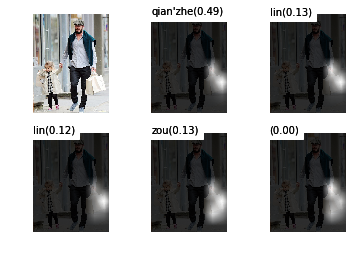

beam search using time(ms): 552.667856216
牵着 袋子 袋子 拎 </S> 0.0158537
probs [0.4874366389777467, 0.18572766860689452, 0.09505901044171451, 0.09941560666921875, 1.170590893200607e-06]


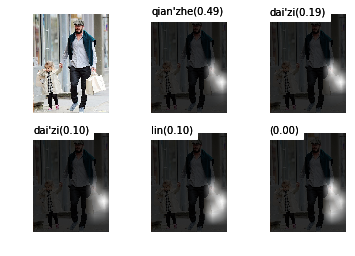

beam search using time(ms): 611.592054367
牵着 牵着 包 走 </S> 0.0157037
probs [0.4874366389777467, 0.23545085727454396, 0.05754718929524545, 0.1300588215483801, 1.1117919153794912e-06]


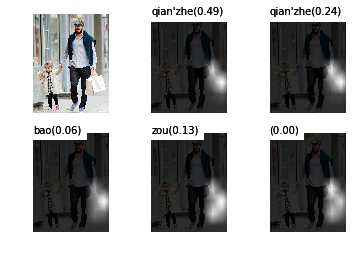

beam search using time(ms): 591.533899307
袋子 牵着 牵着 走 </S> 0.0156458
probs [0.2344876888787167, 0.23496656674164762, 0.11877969318954094, 0.12907552779034462, 1.109865982949509e-06]


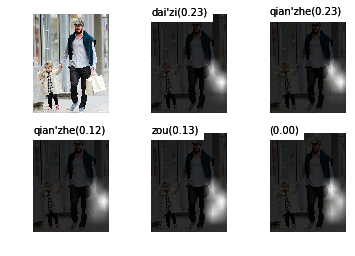

beam search using time(ms): 681.027173996
牵着 拎 走 走 </S> 0.0156152
probs [0.4874366389777467, 0.13095106617174246, 0.10627887660061806, 0.12285189311190332, 1.1139782543167185e-06]


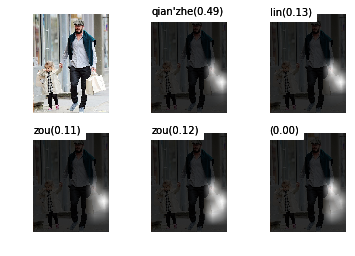

beam search using time(ms): 652.130842209
牵着 牵着 走 牵着 </S> 0.0156088
probs [0.4874366389777467, 0.23545085727454396, 0.10625782209478847, 0.06409832138178821, 1.1852854977946153e-06]


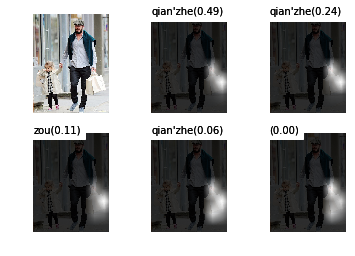

beam search using time(ms): 593.73998642
牵着 牵着 走 道路 </S> 0.0155863
probs [0.4874366389777467, 0.23545085727454396, 0.10625782209478847, 0.06624632697814609, 1.138600243030789e-06]


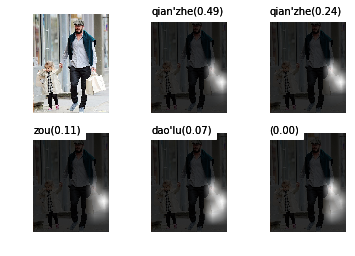

beam search using time(ms): 557.681083679
袋子 牵着 拎 走 </S> 0.0155799
probs [0.2344876888787167, 0.23496656674164762, 0.11636703557129821, 0.12884818525147007, 1.1111877157990268e-06]


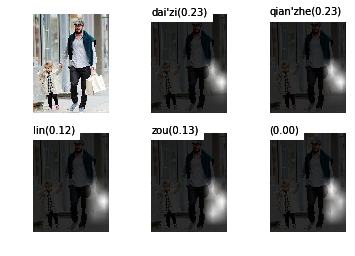

beam search using time(ms): 628.848075867
牵着 牵着 牵着 包 </S> 0.015499
probs [0.4874366389777467, 0.23545085727454396, 0.11901787030550176, 0.05651018408354552, 1.1586822432945268e-06]


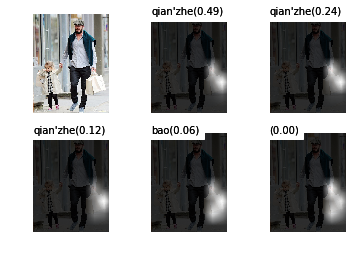

beam search using time(ms): 712.538957596
牵着 牵着 牵着 道路 </S> 0.0154666
probs [0.4874366389777467, 0.23545085727454396, 0.11901787030550176, 0.05722758715463824, 1.1322430090753493e-06]


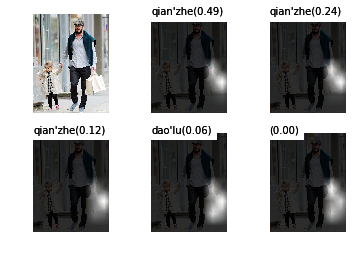

beam search using time(ms): 710.807085037
牵着 拎 牵着 拎 </S> 0.0154496
probs [0.4874366389777467, 0.13095106617174246, 0.11850794115314912, 0.0996581656277172, 1.1676128835423917e-06]


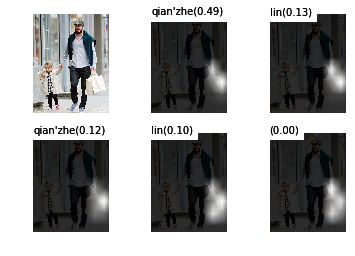

beam search using time(ms): 639.769792557
牵着 牵着 拎 包 </S> 0.0154476
probs [0.4874366389777467, 0.23545085727454396, 0.11648311910579962, 0.05671970064038265, 1.1600731744075753e-06]


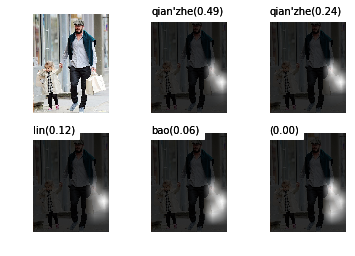

beam search using time(ms): 699.989080429
牵着 牵着 袋子 牵着 </S> 0.015441
probs [0.4874366389777467, 0.23545085727454396, 0.09561247983116125, 0.06780609305634741, 1.1797123216068708e-06]


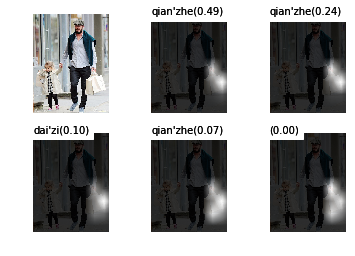

beam search using time(ms): 777.333021164
牵着 牵着 拎 道路 </S> 0.0154266
probs [0.4874366389777467, 0.23545085727454396, 0.11648311910579962, 0.05765434859281625, 1.1335330139386902e-06]


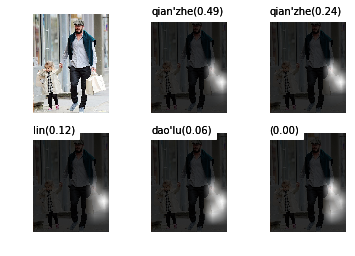

beam search using time(ms): 690.939903259
牵着 拎 拎 拎 </S> 0.0153918
probs [0.4874366389777467, 0.13095106617174246, 0.11638859470532949, 0.09947471463521436, 1.168958793745366e-06]


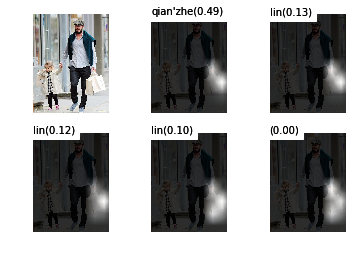

beam search using time(ms): 647.462129593
牵着 拎 袋子 走 </S> 0.0153915
probs [0.4874366389777467, 0.13095106617174246, 0.0948910160761051, 0.1286210591401678, 1.1087593955617176e-06]


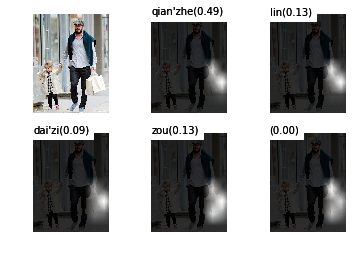

beam search using time(ms): 739.857912064
牵着 袋子 牵着 牵着 </S> 0.0153754
probs [0.4874366389777467, 0.18572766860689452, 0.11848101767826572, 0.06809780794912676, 1.176398054912632e-06]


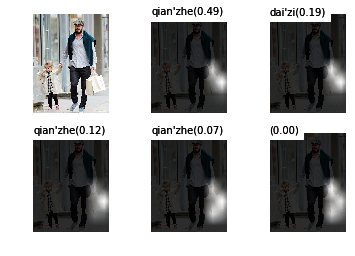

beam search using time(ms): 705.423116684
牵着 袋子 拎 牵着 </S> 0.0153077
probs [0.4874366389777467, 0.18572766860689452, 0.11632919882163549, 0.06776594802391767, 1.1777518454184395e-06]


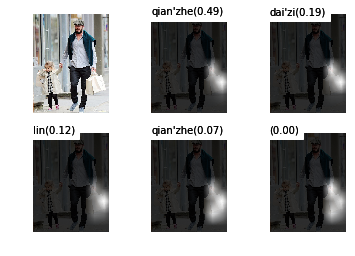

beam search using time(ms): 643.789052963
牵着 牵着 走 包 </S> 0.0151715
probs [0.4874366389777467, 0.23545085727454396, 0.10625782209478847, 0.05650925444882442, 1.1663964376400116e-06]


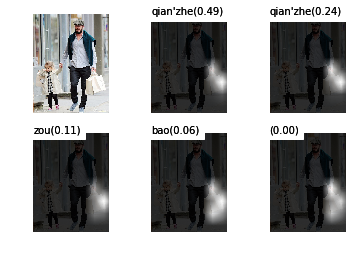

beam search using time(ms): 601.850986481
袋子 牵着 走 走 </S> 0.0151706
probs [0.2344876888787167, 0.23496656674164762, 0.10609646684047448, 0.12309899887965914, 1.1166937956462526e-06]


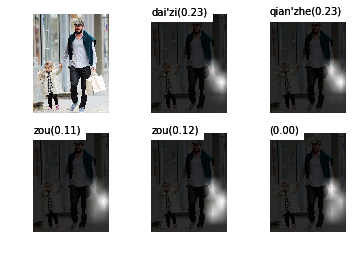

beam search using time(ms): 691.358804703
牵着 牵着 包 拎 </S> 0.0150387
probs [0.4874366389777467, 0.23545085727454396, 0.05754718929524545, 0.09935115669403805, 1.1723102364772506e-06]


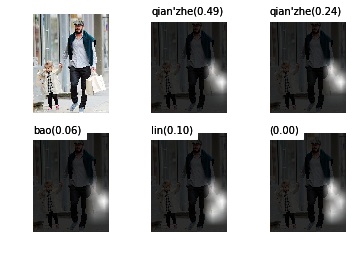

beam search using time(ms): 638.010025024
牵着 拎 走 拎 </S> 0.0150348
probs [0.4874366389777467, 0.13095106617174246, 0.10627887660061806, 0.09640659103875926, 1.1746514316701511e-06]


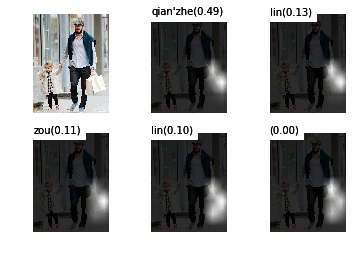

beam search using time(ms): 594.949007034
袋子 牵着 牵着 拎 </S> 0.0150125
probs [0.2344876888787167, 0.23496656674164762, 0.11877969318954094, 0.09956032101524126, 1.1703229968673114e-06]


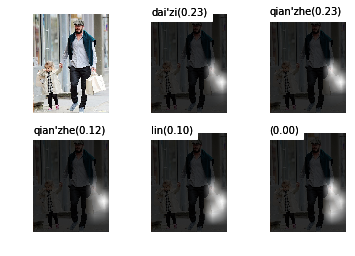

beam search using time(ms): 605.416059494
袋子 牵着 袋子 走 </S> 0.0149731
probs [0.2344876888787167, 0.23496656674164762, 0.0953666474502217, 0.12886969090686512, 1.1114547951094692e-06]


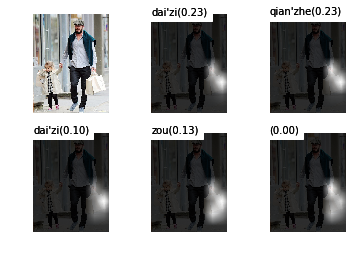

beam search using time(ms): 1068.20988655
牵着 袋子 包 走 </S> 0.0149692
probs [0.4874366389777467, 0.18572766860689452, 0.05768986510456221, 0.12963986059365712, 1.1101009838768593e-06]


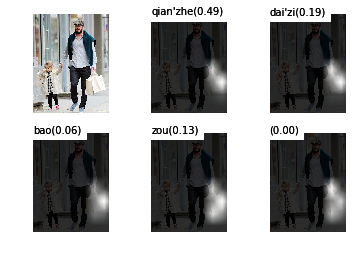

beam search using time(ms): 693.734169006
袋子 牵着 拎 拎 </S> 0.0149489
probs [0.2344876888787167, 0.23496656674164762, 0.11636703557129821, 0.0993771922954501, 1.171675383209854e-06]


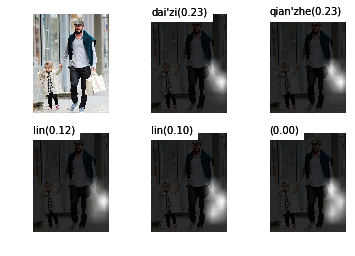

beam search using time(ms): 667.678833008
袋子 袋子 牵着 走 </S> 0.0148881
probs [0.2344876888787167, 0.1850362280633227, 0.11824399947992843, 0.12865749509240026, 1.1081790374513272e-06]


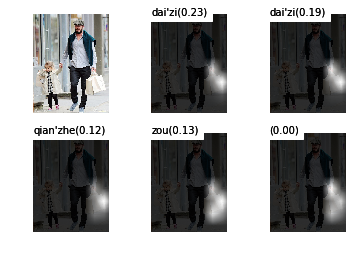

beam search using time(ms): 599.912166595
牵着 牵着 牵着 袋子 </S> 0.0148835
probs [0.4874366389777467, 0.23545085727454396, 0.11901787030550176, 0.045622329609725315, 1.171972648440546e-06]


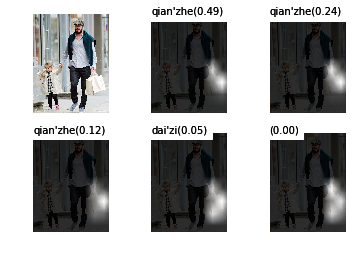

beam search using time(ms): 637.353897095
牵着 袋子 走 牵着 </S> 0.014881
probs [0.4874366389777467, 0.18572766860689452, 0.10635976366416386, 0.06403500782531514, 1.1834895613901765e-06]


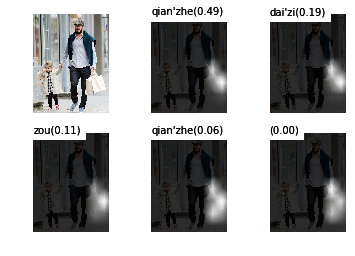

beam search using time(ms): 631.345033646
牵着 袋子 走 道路 </S> 0.014864
probs [0.4874366389777467, 0.18572766860689452, 0.10635976366416386, 0.06628764209477798, 1.136768796331171e-06]


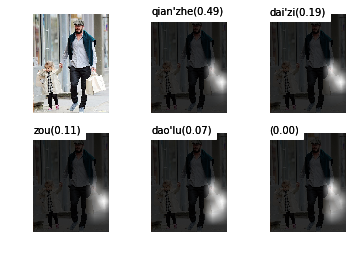

beam search using time(ms): 642.082929611
牵着 牵着 袋子 包 </S> 0.0148375
probs [0.4874366389777467, 0.23545085727454396, 0.09561247983116125, 0.05648018750346779, 1.1603088470573748e-06]


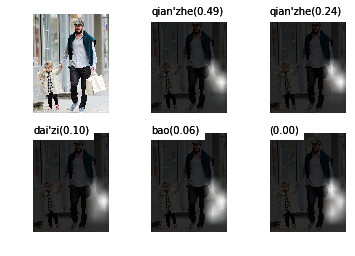

beam search using time(ms): 604.485034943
袋子 袋子 拎 走 </S> 0.0148349
probs [0.2344876888787167, 0.1850362280633227, 0.11621246516751736, 0.12842951093382468, 1.1094945289335878e-06]


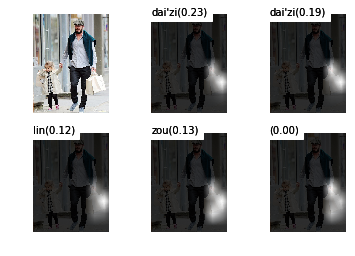

beam search using time(ms): 641.916036606
牵着 牵着 袋子 道路 </S> 0.0148311
probs [0.4874366389777467, 0.23545085727454396, 0.09561247983116125, 0.05767902770612049, 1.1337632948683107e-06]


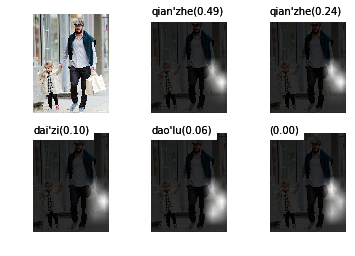

beam search using time(ms): 607.105970383
牵着 牵着 拎 袋子 </S> 0.0148
probs [0.4874366389777467, 0.23545085727454396, 0.11648311910579962, 0.04526934445757286, 1.1733224651870597e-06]


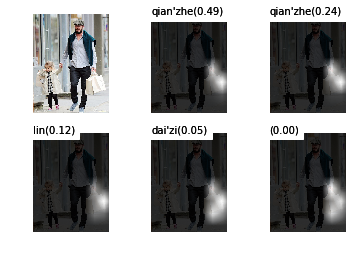

beam search using time(ms): 640.63501358
牵着 拎 袋子 拎 </S> 0.0147747
probs [0.4874366389777467, 0.13095106617174246, 0.0948910160761051, 0.09941605701826475, 1.1691840062450502e-06]


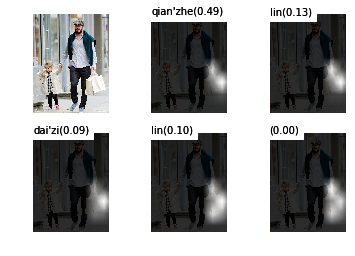

beam search using time(ms): 627.34913826
牵着 袋子 牵着 包 </S> 0.0147574
probs [0.4874366389777467, 0.18572766860689452, 0.11848101767826572, 0.056399153882984145, 1.157011575579417e-06]


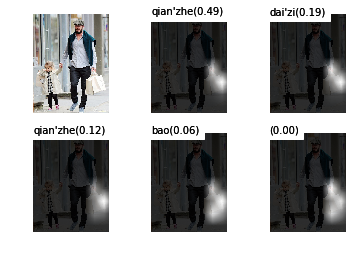

beam search using time(ms): 641.670942307
牵着 袋子 牵着 道路 </S> 0.0147345
probs [0.4874366389777467, 0.18572766860689452, 0.11848101767826572, 0.057276003317510545, 1.1304940199731676e-06]


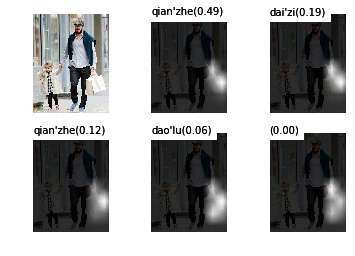

beam search using time(ms): 603.88302803
牵着 袋子 拎 包 </S> 0.0147178
probs [0.4874366389777467, 0.18572766860689452, 0.11632919882163549, 0.05660755697382978, 1.1583949774815025e-06]


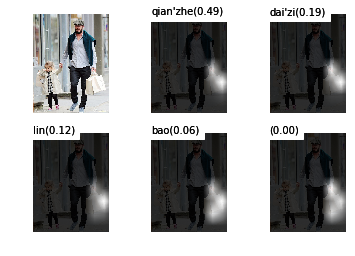

beam search using time(ms): 654.040813446
牵着 袋子 拎 道路 </S> 0.0147058
probs [0.4874366389777467, 0.18572766860689452, 0.11632919882163549, 0.05770257551071032, 1.1317820321508133e-06]


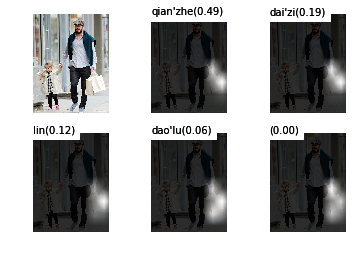

beam search using time(ms): 586.78817749
牵着 袋子 袋子 牵着 </S> 0.0147008
probs [0.4874366389777467, 0.18572766860689452, 0.09505901044171451, 0.06773067106147095, 1.177974258370464e-06]


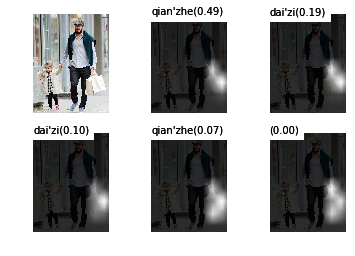

beam search using time(ms): 680.207014084
袋子 牵着 走 拎 </S> 0.0145978
probs [0.2344876888787167, 0.23496656674164762, 0.10609646684047448, 0.09631561290854504, 1.1773801276428037e-06]


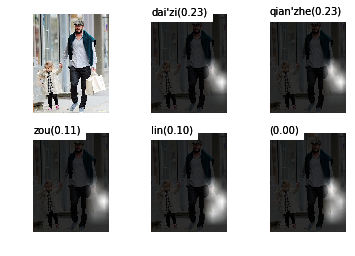

beam search using time(ms): 688.04693222
牵着 袋子 走 包 </S> 0.0144605
probs [0.4874366389777467, 0.18572766860689452, 0.10635976366416386, 0.05638300682091141, 1.1646568890621814e-06]


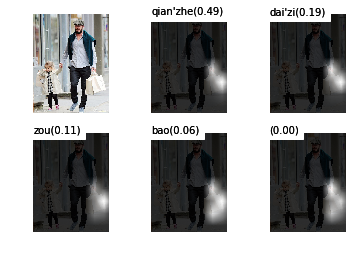

beam search using time(ms): 699.898004532
袋子 袋子 走 走 </S> 0.014451
probs [0.2344876888787167, 0.1850362280633227, 0.10619508870150704, 0.122678500600231, 1.1149124712132578e-06]


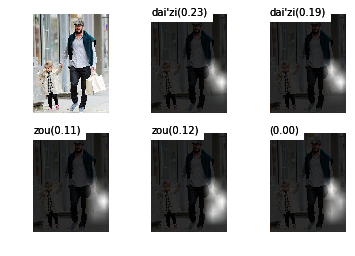

beam search using time(ms): 755.156993866
袋子 牵着 袋子 拎 </S> 0.0143644
probs [0.2344876888787167, 0.23496656674164762, 0.0953666474502217, 0.09931845010856931, 1.1719011190897523e-06]


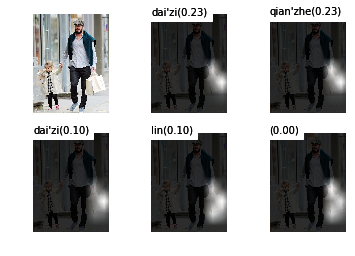

beam search using time(ms): 727.658033371
牵着 袋子 包 拎 </S> 0.0143449
probs [0.4874366389777467, 0.18572766860689452, 0.05768986510456221, 0.09935596530421005, 1.1705786132778493e-06]


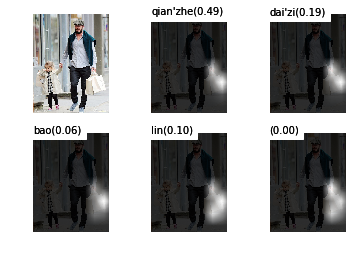

beam search using time(ms): 642.89689064
牵着 拎 牵着 牵着 </S> 0.014336
probs [0.4874366389777467, 0.13095106617174246, 0.11850794115314912, 0.06812923143637706, 1.1749931530109386e-06]


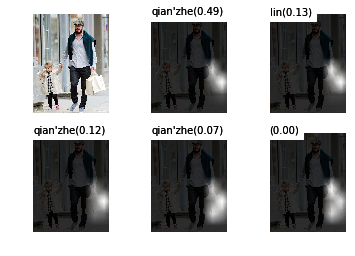

beam search using time(ms): 675.68397522
牵着 牵着 走 袋子 </S> 0.0143127
probs [0.4874366389777467, 0.23545085727454396, 0.10625782209478847, 0.04177302653174191, 1.1790622153447417e-06]


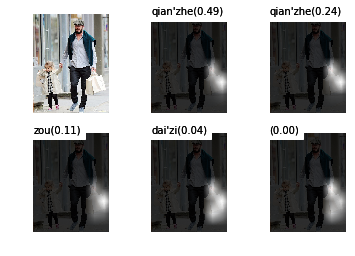

beam search using time(ms): 689.378976822
袋子 袋子 牵着 拎 </S> 0.0142951
probs [0.2344876888787167, 0.1850362280633227, 0.11824399947992843, 0.09956663526551413, 1.1685965379447767e-06]


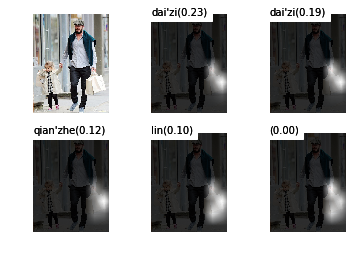

beam search using time(ms): 1036.9181633
牵着 拎 拎 牵着 </S> 0.0142737
probs [0.4874366389777467, 0.13095106617174246, 0.11638859470532949, 0.06779776795779298, 1.1763442049158498e-06]


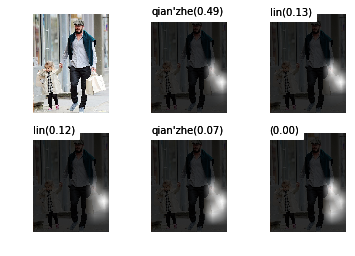

beam search using time(ms): 672.046899796
袋子 袋子 袋子 走 </S> 0.0142444
probs [0.2344876888787167, 0.1850362280633227, 0.09481385512343715, 0.12845030358424736, 1.1097622596296855e-06]


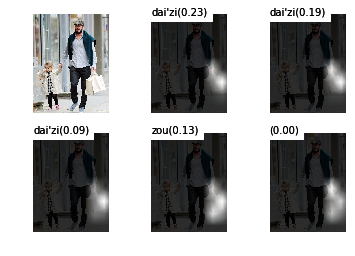

beam search using time(ms): 641.088962555
袋子 袋子 拎 拎 </S> 0.0142437
probs [0.2344876888787167, 0.1850362280633227, 0.11621246516751736, 0.09938337645716414, 1.1699402347779174e-06]


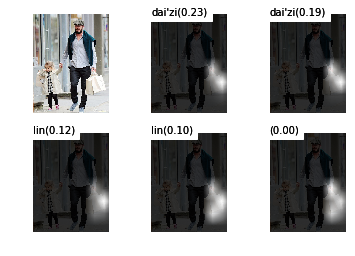

beam search using time(ms): 597.666025162
牵着 牵着 袋子 袋子 </S> 0.0142317
probs [0.4874366389777467, 0.23545085727454396, 0.09561247983116125, 0.04533591093541026, 1.1735485183950378e-06]


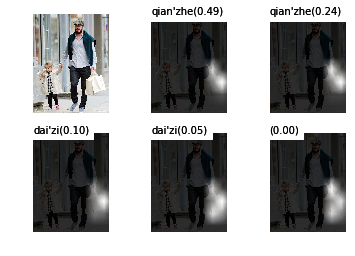

beam search using time(ms): 542.058944702
牵着 袋子 牵着 袋子 </S> 0.0141711
probs [0.4874366389777467, 0.18572766860689452, 0.11848101767826572, 0.045530390291360946, 1.1702415238935135e-06]


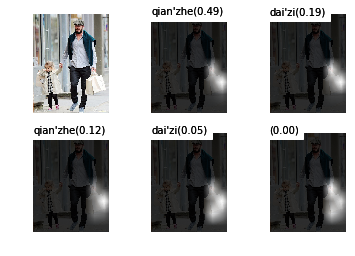

beam search using time(ms): 573.606014252
牵着 袋子 袋子 道路 </S> 0.0141255
probs [0.4874366389777467, 0.18572766860689452, 0.09505901044171451, 0.057727013766436804, 1.1320097982233714e-06]


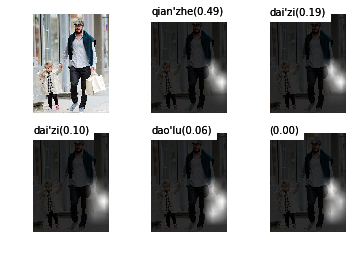

beam search using time(ms): 584.817171097
牵着 牵着 道路 走 </S> 0.0141254
probs [0.4874366389777467, 0.23545085727454396, 0.034881373683389186, 0.12549010310324318, 1.119383930353174e-06]


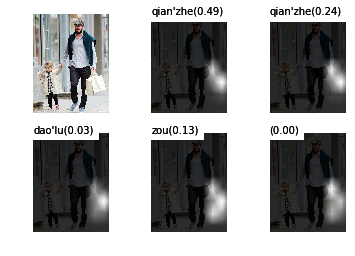

beam search using time(ms): 707.070827484
牵着 袋子 袋子 包 </S> 0.0141238
probs [0.4874366389777467, 0.18572766860689452, 0.09505901044171451, 0.05636783199139851, 1.158631414156617e-06]


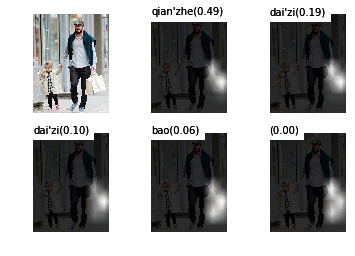

beam search using time(ms): 653.366088867
牵着 袋子 拎 袋子 </S> 0.0141006
probs [0.4874366389777467, 0.18572766860689452, 0.11632919882163549, 0.04517889202459447, 1.1715893468213941e-06]


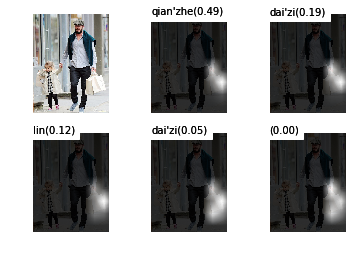

beam search using time(ms): 659.209012985
牵着 拎 包 走 </S> 0.0139659
probs [0.4874366389777467, 0.13095106617174246, 0.05792257515818119, 0.12961454896141122, 1.1087107564421039e-06]


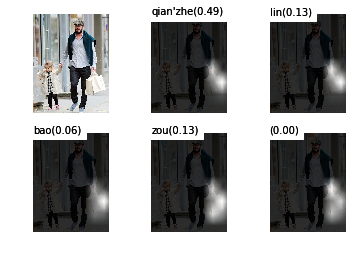

beam search using time(ms): 636.4839077
牵着 牵着 包 牵着 </S> 0.0139431
probs [0.4874366389777467, 0.23545085727454396, 0.05754718929524545, 0.0676361728909264, 1.1797089464276735e-06]


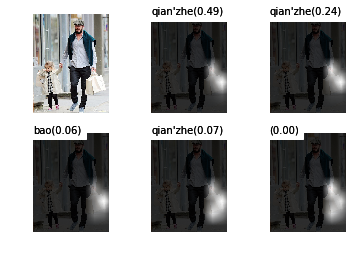

beam search using time(ms): 676.228046417
袋子 牵着 牵着 牵着 </S> 0.0139303
probs [0.2344876888787167, 0.23496656674164762, 0.11877969318954094, 0.0680611736453134, 1.1777080417572888e-06]


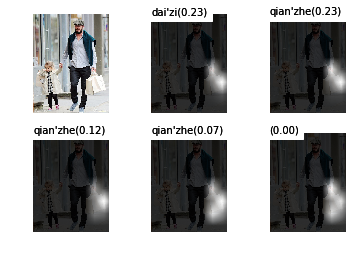

beam search using time(ms): 650.540113449
袋子 袋子 走 拎 </S> 0.0139151
probs [0.2344876888787167, 0.1850362280633227, 0.10619508870150704, 0.09631460252285544, 1.1755793524828355e-06]


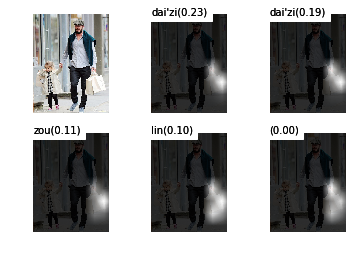

beam search using time(ms): 662.747859955
袋子 拎 牵着 走 </S> 0.0138912
probs [0.2344876888787167, 0.13100152929852624, 0.11827055891780826, 0.1286340927018075, 1.1067986056062997e-06]


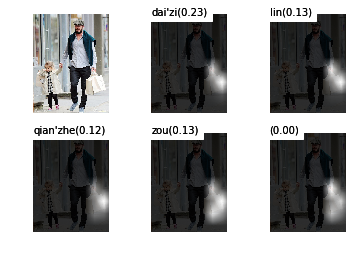

beam search using time(ms): 698.776006699
牵着 拎 走 牵着 </S> 0.0138723
probs [0.4874366389777467, 0.13095106617174246, 0.10627887660061806, 0.06406623673003045, 1.182060408211565e-06]


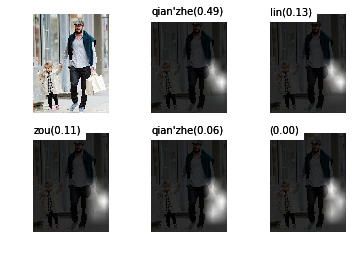

beam search using time(ms): 726.972103119
袋子 牵着 拎 牵着 </S> 0.0138629
probs [0.2344876888787167, 0.23496656674164762, 0.11636703557129821, 0.06772871715136183, 1.1790610909039256e-06]


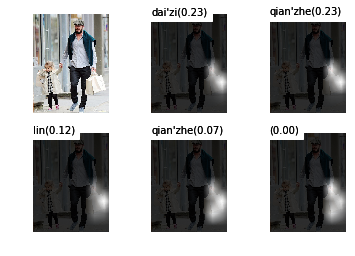

beam search using time(ms): 608.370065689
牵着 拎 走 道路 </S> 0.0138575
probs [0.4874366389777467, 0.13095106617174246, 0.10627887660061806, 0.06634679200201671, 1.1353635785336663e-06]


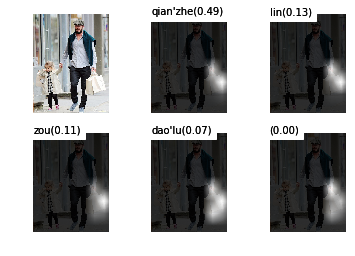

beam search using time(ms): 629.334926605
袋子 拎 拎 走 </S> 0.0138423
probs [0.2344876888787167, 0.13100152929852624, 0.11627227271285484, 0.12840480298577256, 1.1081103448578462e-06]


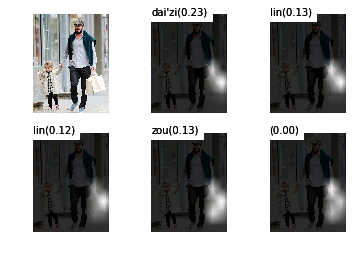

beam search using time(ms): 635.056972504
牵着 牵着 牵着 孩子 </S> 0.0138161
probs [0.4874366389777467, 0.23545085727454396, 0.11901787030550176, 0.031396312931655485, 1.1738429004617277e-06]


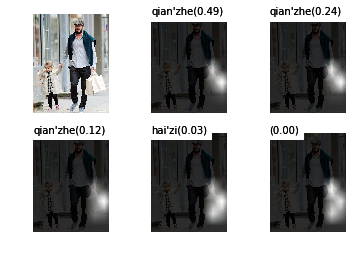

beam search using time(ms): 628.8189888
牵着 牵着 拎 孩子 </S> 0.0137658
probs [0.4874366389777467, 0.23545085727454396, 0.11648311910579962, 0.03146415952749622, 1.1752049580883938e-06]


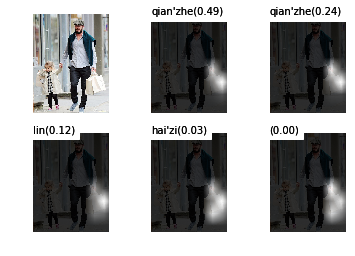

beam search using time(ms): 665.92502594
牵着 拎 牵着 包 </S> 0.01376
probs [0.4874366389777467, 0.13095106617174246, 0.11850794115314912, 0.056429430317040695, 1.155619906983768e-06]


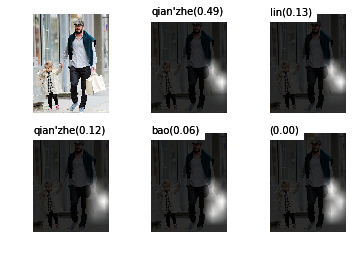

beam search using time(ms): 693.448066711
牵着 拎 牵着 道路 </S> 0.0137398
probs [0.4874366389777467, 0.13095106617174246, 0.11850794115314912, 0.057331403808235225, 1.129114864331252e-06]


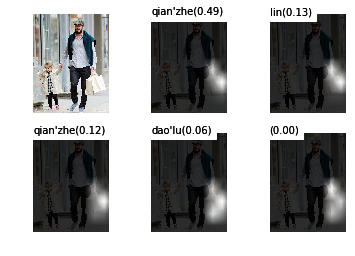

beam search using time(ms): 609.797000885
牵着 拎 拎 包 </S> 0.0137238
probs [0.4874366389777467, 0.13095106617174246, 0.11638859470532949, 0.056637324124359456, 1.1570005415097974e-06]


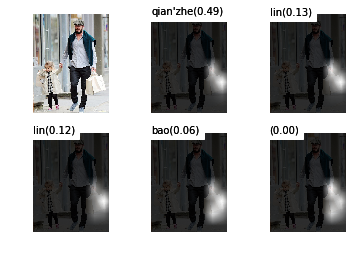

beam search using time(ms): 625.022888184
牵着 拎 拎 道路 </S> 0.0137137
probs [0.4874366389777467, 0.13095106617174246, 0.11638859470532949, 0.05775758991193989, 1.1303980710882114e-06]


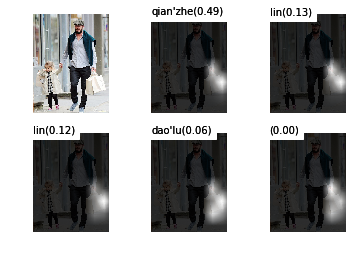

beam search using time(ms): 1140.70296288
牵着 拎 袋子 牵着 </S> 0.0137016
probs [0.4874366389777467, 0.13095106617174246, 0.0948910160761051, 0.06776186051195511, 1.1765663520415199e-06]


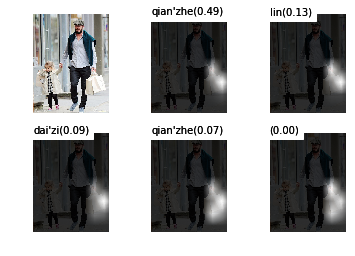

beam search using time(ms): 594.128131866
袋子 袋子 袋子 拎 </S> 0.0136745
probs [0.2344876888787167, 0.1850362280633227, 0.09481385512343715, 0.09932422804138664, 1.1701656363627852e-06]


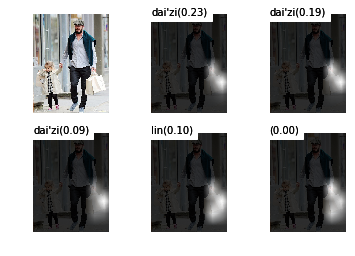

beam search using time(ms): 627.861976624
牵着 袋子 走 袋子 </S> 0.0136434
probs [0.4874366389777467, 0.18572766860689452, 0.10635976366416386, 0.041703398244342826, 1.1772644810923846e-06]


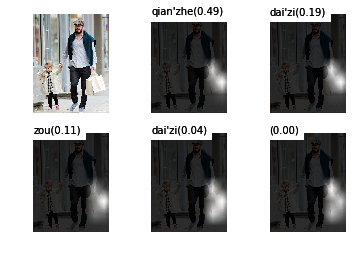

beam search using time(ms): 655.220031738
牵着 牵着 道路 拎 </S> 0.013567
probs [0.4874366389777467, 0.23545085727454396, 0.034881373683389186, 0.0973297906330025, 1.1796796952791247e-06]


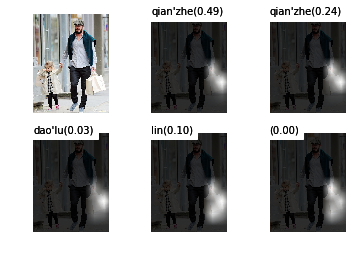

beam search using time(ms): 609.793901443
袋子 牵着 包 走 </S> 0.0135573
probs [0.2344876888787167, 0.23496656674164762, 0.05759366505280251, 0.12986485350221863, 1.1114113373575182e-06]


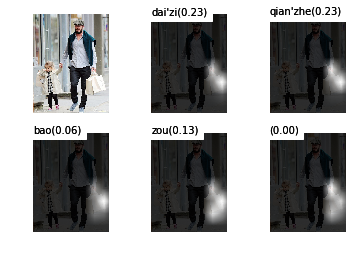

beam search using time(ms): 607.568025589
牵着 袋子 袋子 袋子 </S> 0.013547
probs [0.4874366389777467, 0.18572766860689452, 0.09505901044171451, 0.045245336283639075, 1.1718117135404553e-06]


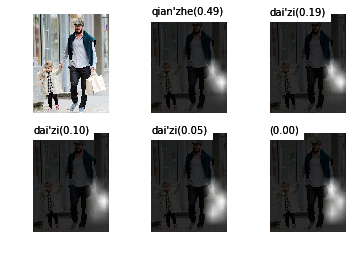

beam search using time(ms): 639.204025269
牵着 袋子 道路 走 </S> 0.013487
probs [0.4874366389777467, 0.18572766860689452, 0.035265174444870144, 0.12506409070374735, 1.1176228289182029e-06]


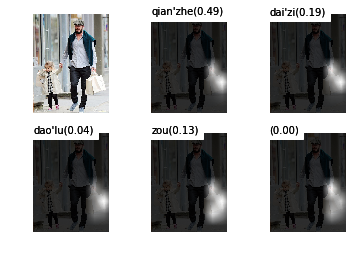

beam search using time(ms): 587.149858475
袋子 拎 走 走 </S> 0.0134804
probs [0.2344876888787167, 0.13100152929852624, 0.1061144533721982, 0.12264580476180693, 1.113501351198778e-06]


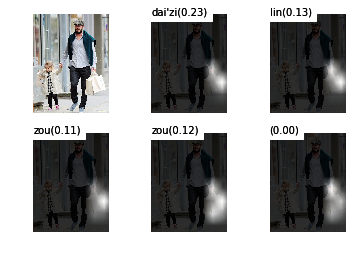

beam search using time(ms): 609.158039093
牵着 牵着 孩子 走 </S> 0.01347
probs [0.4874366389777467, 0.23545085727454396, 0.026956447211761388, 0.1289853914456003, 1.1112555393846741e-06]


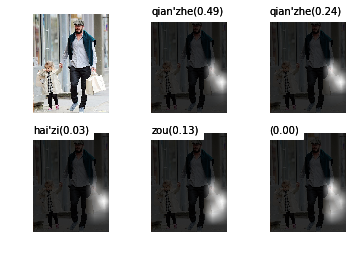

beam search using time(ms): 639.109134674
袋子 牵着 走 道路 </S> 0.0134578
probs [0.2344876888787167, 0.23496656674164762, 0.10609646684047448, 0.06635558756415655, 1.1380802378373782e-06]


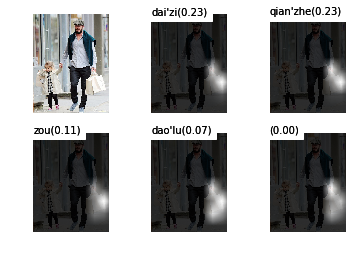

beam search using time(ms): 601.563930511


In [ ]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: ')
  image_name = image_name.strip().replace('file://', '')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)